In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray

# Bayesian analysis
import arviz as az
import bambi as bmb

from pathlib import Path
from collections import defaultdict

from utils.dataUtils import standardize
from utils.plotUtils import ridgeForestPlot, setFontSize, boldStr, spaghettiPlotCategorical, returnPlotDir
from utils.plotParams import getLabels, getPalettes, getLegends
from utils.regression import SEED, returnIDataDir

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_theme(context="paper", 
              style="whitegrid", 
              palette="deep", 
              font="sans-serif", 
              font_scale=1.5, 
              color_codes=True, 
              rc={"lines.linewidth": 0.9})
plt.rcParams.update({"font.size": 12})

In [4]:
DATA_DIR = Path("..", "data")
DATA_FILE1 = DATA_DIR / "abbottVsRocheWildtype.tsv"
DATA_FILE2 = DATA_DIR / "abbottVsRocheOmicron.tsv"

df1 = pd.read_csv(DATA_FILE1, sep="\t")
df2 = pd.read_csv(DATA_FILE2, sep="\t")

In [81]:
pal = getPalettes()
label = getLabels()
legend = getLegends()
plotDir = returnPlotDir()
iDataDir = returnIDataDir()

In [6]:
pal1 = sns.color_palette("colorblind")
labelVl = label.vl
labelRes = "AgPOCT result"

In [78]:
cm = 1/2.54
colWidth = 3.54
fontSizePlot = 12
fontSizePlotSuppl = 10

colWidthAppendix = 10.7 * cm

In [8]:
df = pd.concat([df1, df2])
standardize(df, "vl", "zVl")

# Plots

## Pre-VOC samples

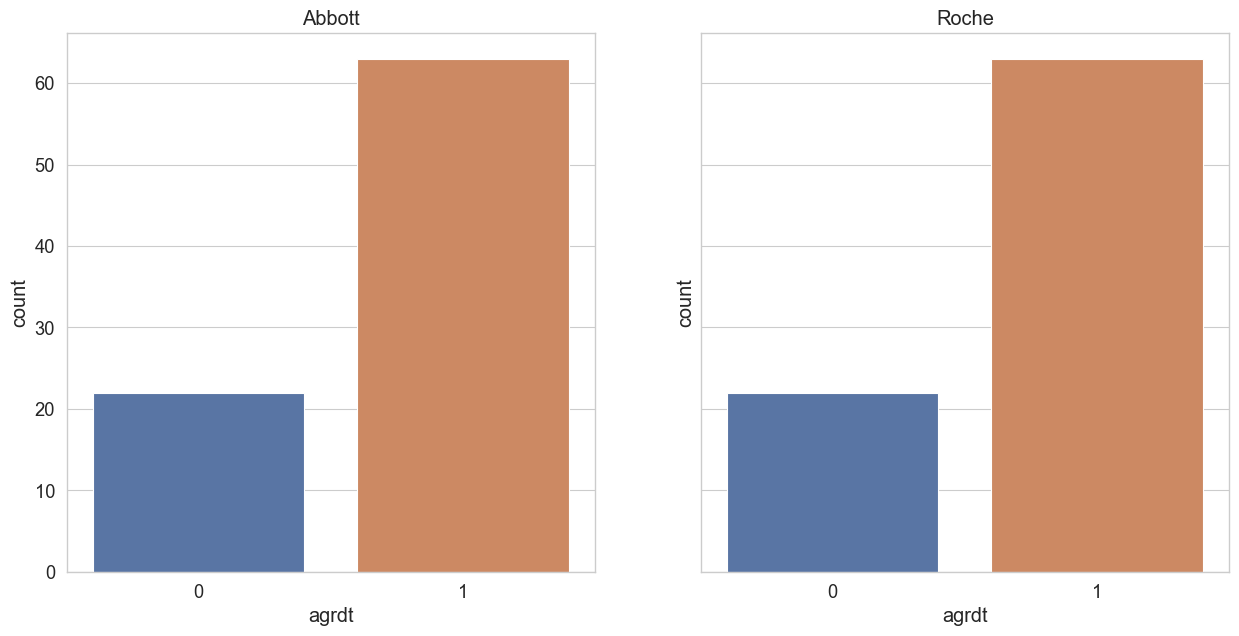

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7), sharey=True)

df1Abbott = df1[df1.test==0].copy()
sns.countplot(data=df1Abbott, x="agrdt", ax=ax[0])
ax[0].set_title("Abbott")
df1Roche = df1[df1.test==1].copy()
sns.countplot(data=df1Roche, x="agrdt", ax=ax[1])
ax[1].set_title("Roche");

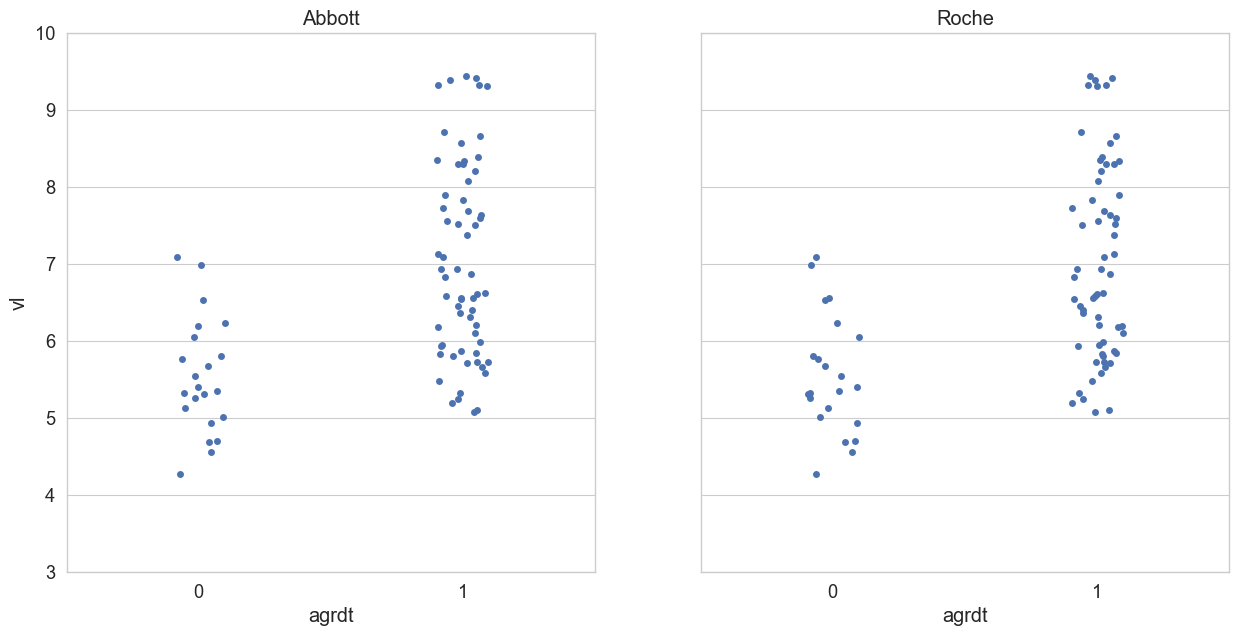

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7), sharey=True)

min_ = 3
max_ = 10

sns.stripplot(x="agrdt", y="vl", data=df1Abbott, ax=ax[0])
ax[0].set_title("Abbott")
ax[0].set_ylim(min_, max_)
sns.stripplot(x="agrdt", y="vl", data=df1Roche, ax=ax[1])
ax[1].set_title("Roche");

## Omicron samples

In [11]:
def jitter(pdSeries):
    return np.random.normal(pdSeries, 0.015)

In [12]:
# Abbott Omicron data
df2Abbott = df2[df2.test==0].copy()
# Roche Omicron data
df2Roche = df2[df2.test==1].copy() 

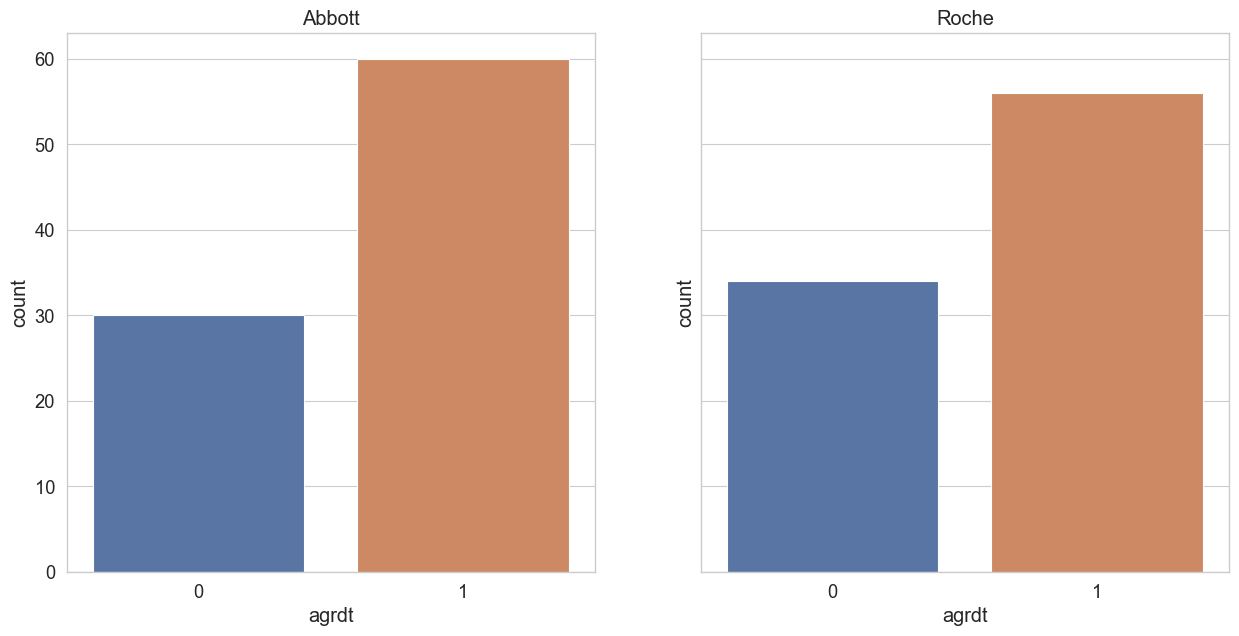

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7), sharey=True)

sns.countplot(data=df2Abbott, x="agrdt", ax=ax[0])
ax[0].set_title("Abbott")
sns.countplot(data=df2Roche, x="agrdt", ax=ax[1])
ax[1].set_title("Roche");

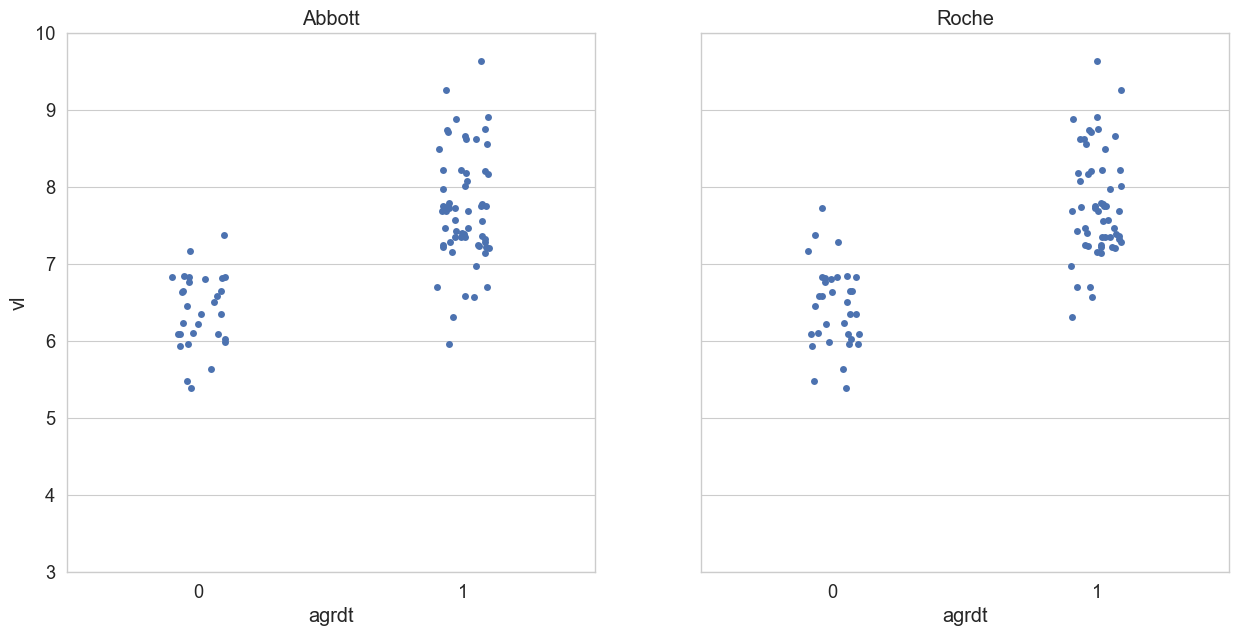

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7), sharey=True)

min_ = 3
max_ = 10

sns.stripplot(x="agrdt", y="vl", data=df2Abbott, ax=ax[0])
ax[0].set_title("Abbott")
ax[0].set_ylim(min_, max_)
sns.stripplot(x="agrdt", y="vl", data=df2Roche, ax=ax[1])
ax[1].set_title("Roche");

#### Check for batch effect

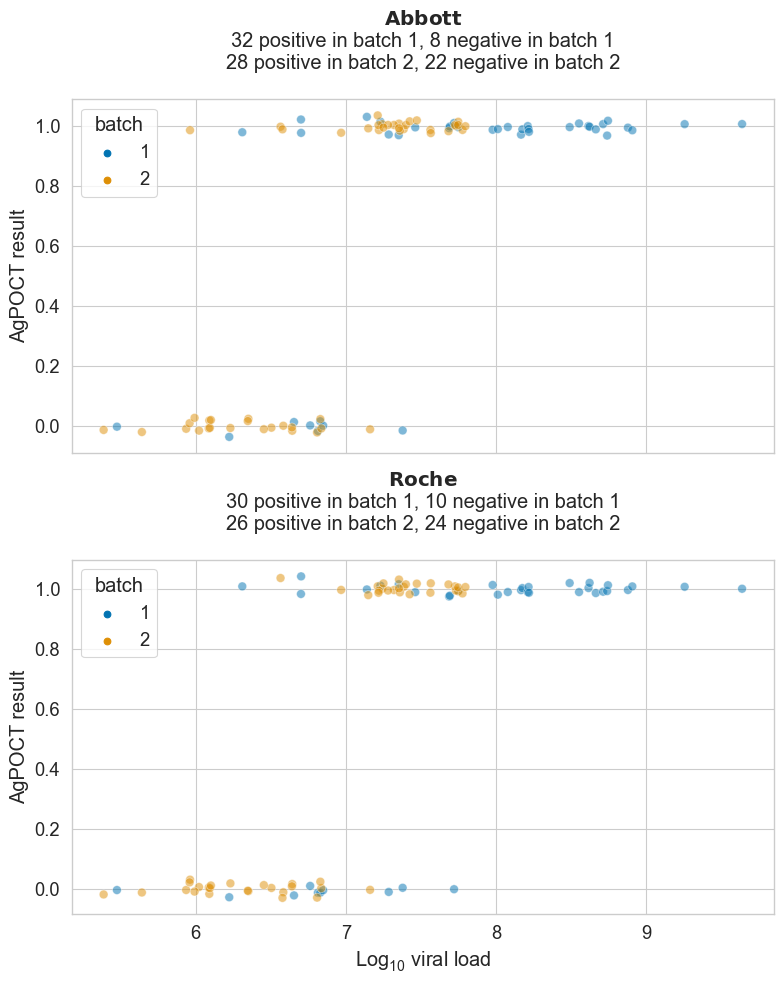

In [15]:
_, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
ax1, ax2 = ax.flatten()
# Abbott
sns.scatterplot(x=df2Abbott.vl, y=jitter(df2Abbott.agrdt), hue=df2Abbott.batch, 
                palette={1: pal1[0], 2: pal1[1]}, s=40, alpha=0.5, ax=ax1)
ax1.set_ylabel(labelRes)
ax1.set_title(f"{boldStr('Abbott')}\n"
              f"{(df2Abbott.agrdt & (df2Abbott.batch==1)).sum()} positive in batch 1, "
              f"{((df2Abbott.agrdt==0) & (df2.batch==1)).sum()} negative in batch 1\n"
              f"{(df2Abbott.agrdt & (df2Abbott.batch==2)).sum()} positive in batch 2, "
              f"{((df2Abbott.agrdt==0) & (df2Abbott.batch==2)).sum()} negative in batch 2\n")
# Roche
sns.scatterplot(x=df2Roche.vl, y=jitter(df2Roche.agrdt), hue=df2Roche.batch, 
                palette={1: pal1[0], 2: pal1[1]}, s=40, alpha=0.5, ax=ax2)
ax2.set_ylabel(labelRes)
ax2.set_title(f"{boldStr('Roche')}\n"
              f"{(df2Roche.agrdt & (df2Roche.batch==1)).sum()} positive in batch 1, "
              f"{((df2Roche.agrdt==0) & (df2Roche.batch==1)).sum()} negative in batch 1\n"
              f"{(df2Roche.agrdt & (df2Roche.batch==2)).sum()} positive in batch 2, "
              f"{((df2Roche.agrdt==0) & (df2Roche.batch==2)).sum()} negative in batch 2\n")


ax2.set_xlabel(labelVl)

plt.tight_layout()
#plt.savefig("output/testForBatchEffect.pdf2", dpi=300)

# Regression

## All data (Pre-VOC and Omicron)

In [33]:
dfBmb = df.copy()
dfBmb = dfBmb.replace({"variant": {"wt": 0, "omicron": 1}})

formula = "agrdt ~ variant + test + (0 + test|variant) + zVl + (0 + zVl|variant + test)"
priors = {"test|variant": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
          "zVl": bmb.Prior("Lognormal", mu=1, sigma=1),
          "zVl|test": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
          "zVl|variant": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1))}
bmbModel = bmb.Model(formula, dfBmb, categorical=["variant", "test"], family="bernoulli", priors=priors, 
                     dropna=True)
bmbModel.build()

In [34]:
bmbModel

Formula: agrdt ~ variant + test + (0 + test|variant) + zVl + (0 + zVl|variant + test)
Family name: Bernoulli
Link: logit
Observations: 350
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 4.3724)
    variant ~ Normal(mu: 0.0, sigma: 5.002)
    test ~ Normal(mu: 0.0, sigma: 5.0)
    zVl ~ Lognormal(mu: 1, sigma: 1)

  Group-level effects
    test|variant ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1))
    zVl|variant ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1))
    zVl|test ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1))

In [35]:
priorPred = bmbModel.prior_predictive()

Sampling: [Intercept, agrdt, test, test|variant_offset, test|variant_sigma, variant, zVl, zVl|test_offset, zVl|test_sigma, zVl|variant_offset, zVl|variant_sigma]


<AxesSubplot: >

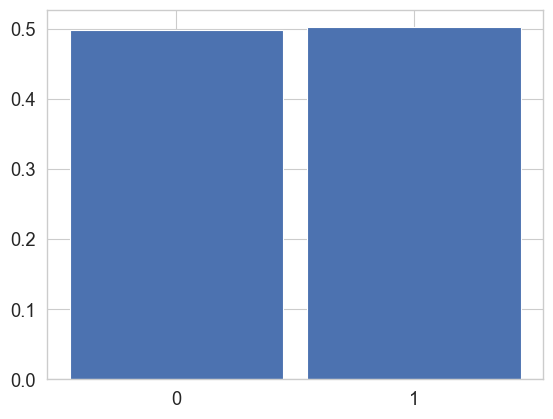

In [19]:
az.plot_dist(priorPred.prior_predictive["agrdt"])

In [36]:
iData = bmbModel.fit(target_accept=0.99, draws=5000, tune=4000)

Modeling the probability that agrdt==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, variant, test, zVl, test|variant_sigma, test|variant_offset, zVl|variant_sigma, zVl|variant_offset, zVl|test_sigma, zVl|test_offset]


Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 431 seconds.


In [82]:
iData.to_netcdf(iDataDir + "/abbottRocheWtOmicron.nc")

'../output/iData//abbottRocheWtOmicron.nc'

/Users/leoniemeiners/miniconda3/envs/agrdt-study/lib/python3.10/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['abbott-roche_variant'] have not been found and will be ignored
  warnings.warn(


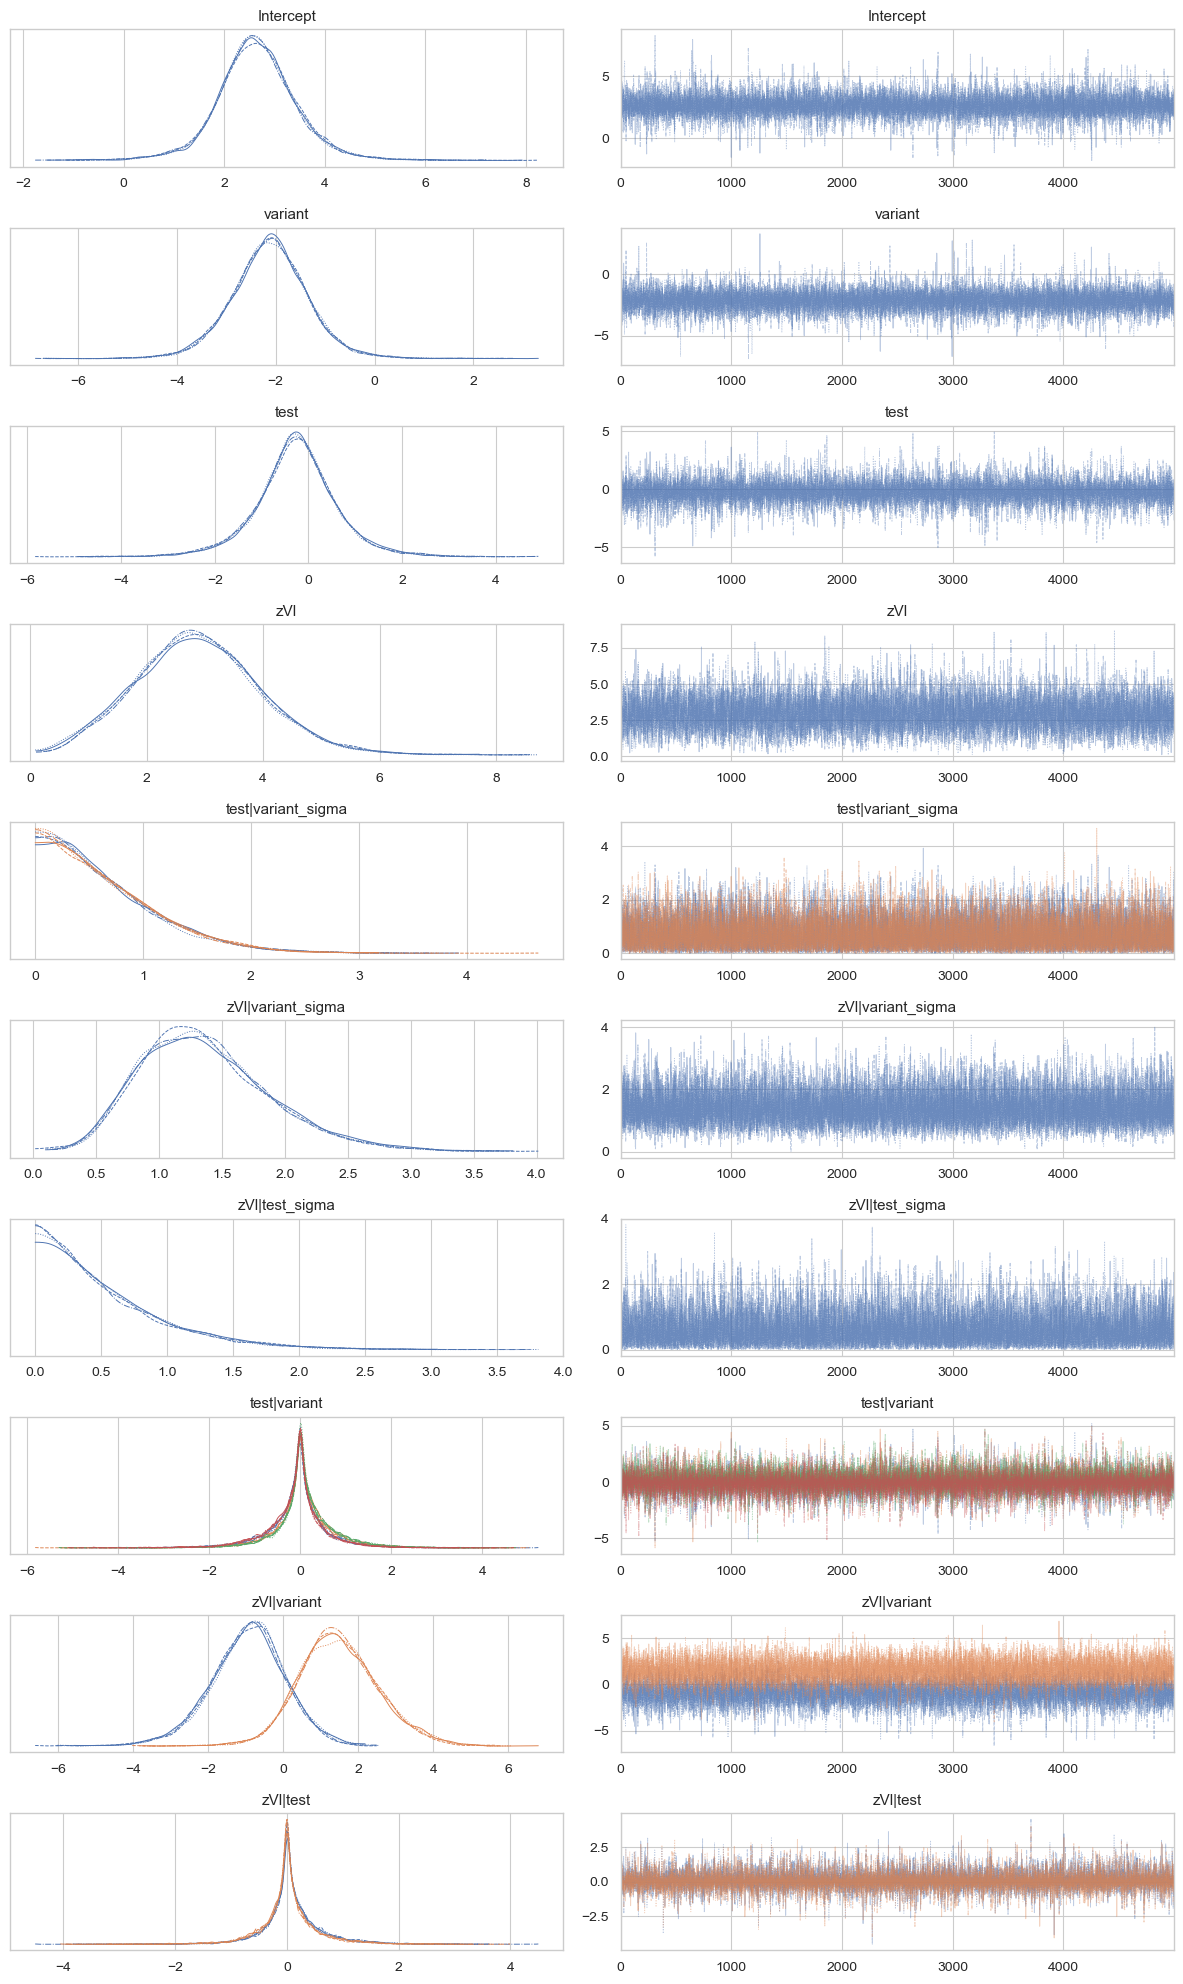

In [37]:
az.plot_trace(iData, var_names=["~abbott-roche_variant"], compact=True);
plt.tight_layout()

In [38]:
az.summary(iData, "~agrdt_mean")

/Users/leoniemeiners/miniconda3/envs/agrdt-study/lib/python3.10/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['agrdt_mean'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.644,0.809,1.034,4.130,0.008,0.006,11575.0,10005.0,1.0
variant[1],-2.121,0.794,-3.599,-0.642,0.007,0.005,12992.0,11158.0,1.0
test[1],-0.256,0.887,-2.023,1.437,0.009,0.007,10282.0,10142.0,1.0
zVl,2.880,1.083,0.822,4.824,0.012,0.008,7975.0,8210.0,1.0
test|variant_sigma[0],0.647,0.521,0.000,1.598,0.005,0.003,10532.0,10618.0,1.0
test|variant_sigma[1],0.650,0.520,0.000,1.596,0.005,0.003,9731.0,8708.0,1.0
zVl|variant_sigma,1.366,0.521,0.471,2.359,0.004,0.003,13954.0,10286.0,1.0
zVl|test_sigma,0.537,0.475,0.000,1.417,0.004,0.003,10417.0,7573.0,1.0
"test|variant[0, 0]",-0.054,0.681,-1.437,1.320,0.007,0.005,11164.0,10815.0,1.0
"test|variant[0, 1]",0.067,0.677,-1.259,1.448,0.007,0.005,10982.0,11470.0,1.0


##### Process test|variant - compute differences between tests

In [39]:
iData2 = iData.copy()

In [40]:
postTest = iData.posterior["test"]

In [25]:
# codes for variable "test": 0: Abbott, 1: Roche
# codes for variabel "variant": 0: wt, 1: omicron

In [41]:
abbott_wt = iData.posterior.sel(test__expr_dim="0", variant__factor_dim="0")["test|variant"]
roche_wt = iData.posterior.sel(test__expr_dim="1", variant__factor_dim="0")["test|variant"]

abbott_omicron = iData.posterior.sel(test__expr_dim="0", variant__factor_dim="1")["test|variant"]
roche_omicron = iData.posterior.sel(test__expr_dim="1", variant__factor_dim="1")["test|variant"]

In [42]:
roche_abbott_omicron = (postTest + roche_omicron - abbott_omicron).rename({"variant__factor_dim": "roche_abbott_variant"})
roche_abbott_omicron["roche_abbott_variant"] = "omicron"

In [43]:
roche_abbott_wt = (postTest + roche_wt - abbott_wt).rename({"variant__factor_dim": "roche_abbott_variant"})
roche_abbott_wt["roche_abbott_variant"] = "pre-VOC"

In [44]:
abbottRoche = xarray.concat([roche_abbott_wt, roche_abbott_omicron], dim="new_dim")
abbottRoche.name="roche_abbott_variant"

In [45]:
iData.posterior["roche_abbott_variant"] = abbottRoche

##### Process zVl|test - compute differences between tests

In [46]:
postZVl = iData.posterior["zVl"]

In [47]:
abbott_zVl = postZVl + iData.posterior.sel(test__factor_dim="0")["zVl|test"]
roche_zVl = postZVl + iData.posterior.sel(test__factor_dim="1")["zVl|test"]

In [48]:
abbott_zVl["test__factor_dim"] = "abbott"
abbott_zVl["test__factor_dim"] = "roche"

In [49]:
zVlAbbottRoche = xarray.concat([abbott_zVl, roche_zVl], dim="new_dim")
zVlAbbottRoche.name="zVl_roche_abbott"

In [50]:
iData.posterior["zVl_roche_abbott"] = zVlAbbottRoche

##### Process zVl|variant - compute difference between variants

In [51]:
wt_zVl = postZVl + iData.posterior.sel(variant__factor_dim="0")["zVl|variant"]
omicron_zVl = postZVl + iData.posterior.sel(variant__factor_dim="1")["zVl|variant"]

In [52]:
wt_zVl["variant__factor_dim"] = "wt"
omicron_zVl["variant__factor_dim"] = "omicron"

In [53]:
zVlWtOmicron = xarray.concat([wt_zVl, omicron_zVl], dim="new_dim")
zVlWtOmicron.name="zVl_wt_omicron"

In [54]:
iData.posterior["zVl_wt_omicron"] = zVlWtOmicron

##### Plots

In [55]:
var_names = ["roche_abbott_variant", "zVl_roche_abbott", "variant", "zVl_wt_omicron"]

#### Plotting

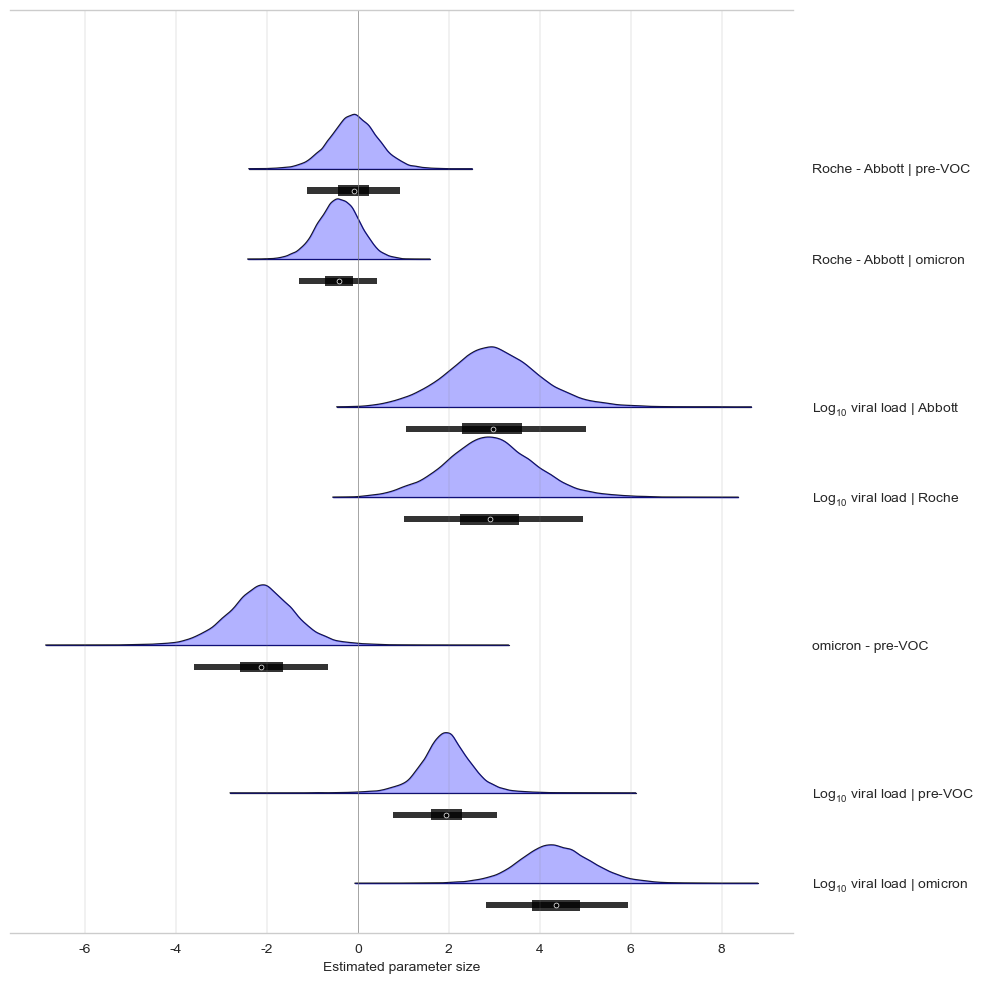

In [56]:
ax = ridgeForestPlot(iData, varNames=tuple(var_names), 
                     yTickLabels=("Roche - Abbott | pre-VOC", 
                                  "Roche - Abbott | omicron",
                                  f"{label.vl} | Abbott", 
                                  f"{label.vl} | Roche", 
                                  "omicron - pre-VOC",
                                  f"{label.vl} | pre-VOC",
                                  f"{label.vl} | omicron",))
plt.show()

#### Posterior predictions

In [57]:
vlMean = df.vl.mean()
vlSd = df.vl.std()
nCats = 2

vl = np.arange(3, 11, step=0.1)
zVl = (vl - vlMean) / vlSd
nVl = len(zVl)
n = nCats * nVl

dtype = np.int32

In [58]:
# Displaying difference for variant:
newData = pd.DataFrame({
    "variant": np.repeat([0, 1], nVl),
    "test": np.zeros(n, dtype=dtype),
    "zVl": np.tile(zVl, nCats),
})

# Displaying difference for rapid test:
newData2 = pd.DataFrame({
    "variant": np.ones(n, dtype=dtype),
    "test": np.repeat([0, 1], nVl),
    "zVl": np.tile(zVl, nCats),
})

In [59]:
bmbModel.predict(iData, data=newData)

In [60]:
predDict = defaultdict(dict)
predDict["variant"]["vl"] = vl
predDict["variant"]["data"] = newData
predDict["variant"]["ppSamples"] = iData.posterior["agrdt_mean"].stack(samples=("chain", "draw")).values

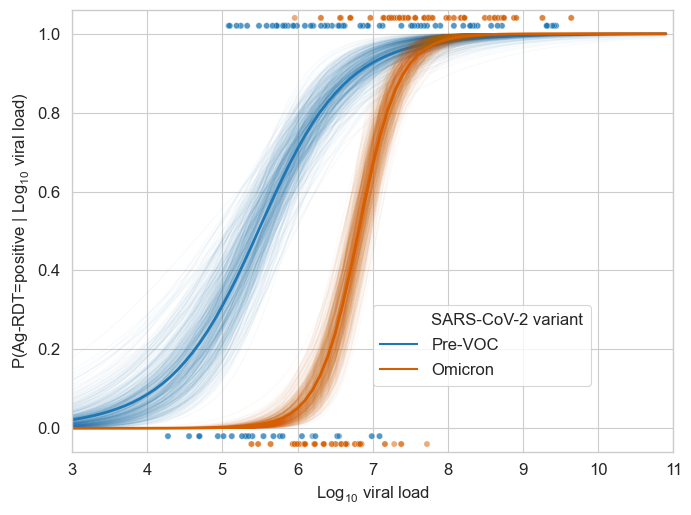

In [64]:
_, ax = plt.subplots(1, 1, figsize=(colWidth*2, colWidth*1.5))

palette = {i: pal.variant[variant] for i, variant in enumerate(("wildtype", "omicron"))}
spaghettiPlotCategorical(ax, "variant", (0, 1), predDict, dfBmb, palette=palette, legend=legend.variantLinesWtOmicron)
setFontSize(ax, size=fontSizePlot) 

plt.tight_layout()
plt.savefig(f"{plotDir}/FigureOmicronAbbott.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/FigureOmicronAbbott.pdf", dpi=600, bbox_inches="tight")

# Only Omicron samples

In [65]:
formula = "agrdt ~ test + zVl + (0 + zVl|test)"
priors = {"zVl": bmb.Prior("Lognormal", mu=1, sigma=1),
          "zVl|test": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),}
bmbModel2 = bmb.Model(formula, df2, categorical=["test"], family="bernoulli", priors=priors, 
                     dropna=True)
bmbModel2.build()

In [66]:
bmbModel2

Formula: agrdt ~ test + zVl + (0 + zVl|test)
Family name: Bernoulli
Link: logit
Observations: 180
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 3.5355)
    test ~ Normal(mu: 0.0, sigma: 5.0)
    zVl ~ Lognormal(mu: 1, sigma: 1)

  Group-level effects
    zVl|test ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1))

In [67]:
iData2 = bmbModel2.fit(target_accept=0.99, draws=10000, tune=4000, random_seed=SEED)

Modeling the probability that agrdt==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, test, zVl, zVl|test_sigma, zVl|test_offset]


Sampling 4 chains for 4_000 tune and 10_000 draw iterations (16_000 + 40_000 draws total) took 110 seconds.


In [83]:
iData2.to_netcdf(iDataDir + "/figA1.nc")

'../output/iData//figA1.nc'

##### Process zVl|test - compute differences between tests

In [69]:
postZVl = iData2.posterior["zVl"]

In [70]:
abbott_zVl = postZVl + iData2.posterior.sel(test__factor_dim="0")["zVl|test"]
roche_zVl = postZVl + iData2.posterior.sel(test__factor_dim="1")["zVl|test"]

In [71]:
abbott_zVl["test__factor_dim"] = "abbott"
abbott_zVl["test__factor_dim"] = "roche"

In [72]:
zVlAbbottRoche = xarray.concat([abbott_zVl, roche_zVl], dim="new_dim")
zVlAbbottRoche.name="zVl_roche_abbott"

In [73]:
iData2.posterior["zVl_roche_abbott"] = zVlAbbottRoche

In [74]:
az.summary(iData2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.891,0.453,1.066,2.759,0.003,0.002,22729.0,22276.0,1.0
test[1],-0.494,0.564,-1.547,0.561,0.004,0.003,25481.0,24621.0,1.0
zVl,3.643,0.800,2.165,5.214,0.007,0.005,14241.0,9468.0,1.0
zVl|test_sigma,0.637,0.516,0.000,1.576,0.004,0.003,13409.0,13385.0,1.0
zVl|test[0],0.060,0.668,-1.273,1.460,0.006,0.004,16170.0,13595.0,1.0
zVl|test[1],0.120,0.660,-1.141,1.522,0.006,0.004,16166.0,14342.0,1.0
zVl_roche_abbott[0],3.703,0.640,2.545,4.934,0.004,0.003,27240.0,29472.0,1.0
zVl_roche_abbott[1],3.763,0.653,2.552,4.987,0.004,0.003,30824.0,31536.0,1.0


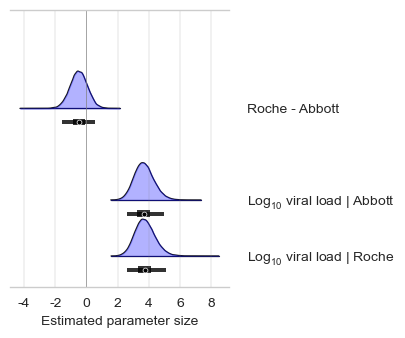

In [79]:
ax = ridgeForestPlot(iData2, varNames=("test", "zVl_roche_abbott"), 
                     yTickLabels=("Roche - Abbott", 
                                  f"{label.vl} | Abbott", 
                                  f"{label.vl} | Roche", ),
                    figsize=(colWidthAppendix, colWidth), fontsize=fontSizePlotSuppl)
plt.tight_layout()
plt.savefig(f"{plotDir}/FigureA1.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{plotDir}/FigureA1.pdf", dpi=600, bbox_inches="tight")